In [1]:
# load the module
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append("../Qtensor")
sys.path.append("../Qtensor/qtree_git")
sys.path.append("../Qtensor/qtree_git/qtree")
sys.path.append("..")


from qtensor import ZZQtreeQAOAComposer, ZZQtreeQAOAComposer_MIS, ZZQtreeQAOAComposer_MAXCUT
from qtensor import QAOAQtreeSimulator, QAOAQtreeSimulator_MIS, QAOAQtreeSimulator_MAXCUT
from qtensor.contraction_backends import TorchBackend
import Generating_Problems as Generator
from Calculating_Expectation_Values import SingleLayerQAOAExpectationValues, QtensorQAOAExpectationValuesMIS,QtensorQAOAExpectationValuesMAXCUT,QtensorQAOAExpectationValuesQUBO
from QIRO import QIRO_MIS
import RQAOA
import torch
import qtensor
import networkx as nx
import numpy as np
from scipy.optimize import minimize
import tqdm
from scipy.optimize import Bounds
import pprint
from functools import partial
import random
import json
import matplotlib.pyplot as plt

/Users/Q642074/miniconda3/envs/qiro/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
graph = nx.random_regular_graph(3, 12)

In [16]:
problem = Generator.MIS(graph)
expectation_values_qtensor = QtensorQAOAExpectationValuesQUBO(problem, 1, opt=torch.optim.SGD, opt_kwargs=dict(lr=0.0001))
expectation_values_qtensor.optimize()

correlations_qtensor=expectation_values_qtensor.expect_val_dict

#expectation_values_qtensor = QtensorQAOAExpectationValuesMAXCUT(problem, p, initialization='fixed_angles_optimization', opt=torch.optim.SGD, opt_kwargs=dict(lr=0.0001))    
#RQAOA_qtensor = RQAOA(expectation_values_qtensor, 5, type_of_problem="MAXCUT")
#RQAOA_qtensor = RQAOA.RQAOA(expectation_values_qtensor, 5, type_of_problem="MAXCUT")

100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


In [17]:
print(correlations_qtensor)

{frozenset({1}): 0.09980558616449625, frozenset({2}): 0.09980558616449614, frozenset({2, 3}): -0.14537842901707052, frozenset({3}): 0.09980558616449614, frozenset({1, 4}): -0.1378655560788435, frozenset({4}): 0.09980558616449603, frozenset({5}): 0.09980558616449614, frozenset({5, 6}): -0.13029394355757248, frozenset({6}): 0.09980558616449603, frozenset({3, 7}): -0.14537842901707052, frozenset({5, 7}): -0.13786555607884346, frozenset({6, 7}): -0.13786555607884346, frozenset({7}): 0.09980558616449603, frozenset({8, 1}): -0.13786555607884346, frozenset({8, 3}): -0.14537842901707052, frozenset({8, 4}): -0.13786555607884346, frozenset({8}): 0.09980558616449603, frozenset({9, 2}): -0.1453784290170706, frozenset({9, 4}): -0.14537842901707052, frozenset({9}): 0.09980558616449625, frozenset({9, 10}): -0.14537842901707052, frozenset({10}): 0.09980558616449614, frozenset({11, 5}): -0.13786555607884346, frozenset({11, 6}): -0.13786555607884346, frozenset({10, 11}): -0.14537842901707052, frozenset(

In [18]:
for key in correlations_qtensor.copy().keys():
                if len(key)==2:
                    del correlations_qtensor[key]

In [19]:
print(correlations_qtensor)

{frozenset({1}): 0.09980558616449625, frozenset({2}): 0.09980558616449614, frozenset({3}): 0.09980558616449614, frozenset({4}): 0.09980558616449603, frozenset({5}): 0.09980558616449614, frozenset({6}): 0.09980558616449603, frozenset({7}): 0.09980558616449603, frozenset({8}): 0.09980558616449603, frozenset({9}): 0.09980558616449625, frozenset({10}): 0.09980558616449614, frozenset({11}): 0.09980558616449614, frozenset({12}): 0.09980558616449603}


In [3]:
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

In [4]:
n_wires = graph.number_of_nodes()
#graph = [(0, 1), (0, 3), (1, 2), (2, 3)]



# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph.edges():
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

In [5]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

In [7]:
#dev = qml.device("default.qubit", wires=n_wires)
dev = qml.device("qulacs.simulator", wires=n_wires)


In [8]:
@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample()
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph.edges():
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        return neg_obj
    
    def correlations(params):
        gammas = params[0]
        betas = params[1]
        correlations_dict={}
        for edge in graph.edges():
            correlation = circuit(gammas, betas, edge=edge, n_layers=n_layers)
            correlations_dict[edge]=correlation
            print(correlation)
        return correlations_dict

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.3)

    # optimize parameters in objective
    params = init_params
    steps = 50
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    #for i in range(0, n_samples):
    #    bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))
    # print optimal parameters and most frequently sampled bitstring
    #counts = np.bincount(np.array(bit_strings))
    #most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    #print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params), bit_strings, correlations(params)


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
objective_p1, bitstring_p1, correlations_statevector_p1 = qaoa_maxcut(n_layers=1)
objective_p2, bitstring_p2, correlations_statevector_p2 = qaoa_maxcut(n_layers=2)


p=1
Objective after step     5:  12.2700095
Objective after step    10:  16.2719592
Objective after step    15:  16.4453517
Objective after step    20:  16.4559398
Objective after step    25:  16.4561084
Objective after step    30:  16.4561110
Objective after step    35:  16.4561110
Objective after step    40:  16.4561110
Objective after step    45:  16.4561110
Objective after step    50:  16.4561110
Optimized (gamma, beta) vectors:
[[-0.60695569]
 [ 0.38379082]]
-0.3845718386878988
-0.38457183868789313
-0.38457183868789785
-0.3845718386878986
-0.38457183868789646
-0.3845718386879023
-0.3845718386878964
-0.38457183868790107
-0.38457183868789785
-0.3845718386879032
-0.3845718386879
-0.3845718386879004
-0.3845718386878947
-0.38457183868788897
-0.38457183868789446
-0.3845718386879005
-0.3845718386879035
-0.3845718386879027
-0.2787378159286318
-0.27873781592863045
-0.3845718386879021
-0.2787378159286355
-0.3845718386879007
-0.38457183868789896

p=2
Objective after step     5:  14.8898736


In [ ]:
init_params = 0.01 * np.random.rand(2, 2, requires_grad=True)

In [10]:
print(correlations_qtensor)
print(correlations_statevector_p2)

{frozenset({1, 3}): -0.5195378626403508, frozenset({2, 3}): -0.5195378626403511, frozenset({2, 4}): -0.5233645873982712, frozenset({1, 5}): -0.516984800433533, frozenset({2, 7}): -0.47191346438026827, frozenset({8, 5}): -0.4594409586704471, frozenset({9, 7}): -0.5040662422480026, frozenset({10, 3}): -0.5699120562826321, frozenset({10, 4}): -0.5129184531209331, frozenset({10, 5}): -0.5129184531209331, frozenset({9, 11}): -0.2964922910605696, frozenset({12, 6}): -0.5040662422480028, frozenset({9, 12}): -0.29034496551296707, frozenset({11, 12}): -0.29649229106056957, frozenset({8, 13}): -0.4644419801010143, frozenset({4, 14}): -0.4656549226541945, frozenset({6, 14}): -0.4704690185036834, frozenset({8, 14}): -0.46444198010101434, frozenset({6, 15}): -0.4644419801010143, frozenset({15, 7}): -0.4704690185036834, frozenset({13, 15}): -0.4704690185036834, frozenset({16, 1}): -0.46565492265419445, frozenset({16, 11}): -0.510256296288494, frozenset({16, 13}): -0.47046901850368344}
{(4, 9): tenso

In [18]:
for i, j in correlations_statevector_p2.keys():
    print(correlations_statevector_p2[i, j])
    print(correlations_qtensor[frozenset({i+1,j+1})])
    print()

-0.5286010998697231
-0.5129184531209331

-0.5334718279621588
-0.516984800433533

-0.46835909753484806
-0.4594409586704471

-0.5286010998697231
-0.5129184531209331

-0.5921787774012762
-0.5699120562826321

-0.481380854541618
-0.4704690185036834

-0.5193258570264919
-0.5040662422480028

-0.4742889667014641
-0.4644419801010143

-0.4756716680196184
-0.4656549226541945

-0.47428896670146575
-0.46444198010101434

-0.5408707005761172
-0.5233645873982712

-0.5363625556914767
-0.5195378626403508

-0.4756716680196171
-0.46565492265419445

-0.5363625556914767
-0.5195378626403511

-0.4830576391979945
-0.47191346438026827

-0.5193258570264916
-0.5040662422480026

-0.48138085454161705
-0.4704690185036834

-0.526867046848258
-0.510256296288494

-0.30431171492413833
-0.29649229106056957

-0.3043117149241379
-0.2964922910605696

-0.48138085454161805
-0.47046901850368344

-0.29665268510471143
-0.29034496551296707

-0.4813808545416143
-0.4704690185036834

-0.4742889667014655
-0.4644419801010143



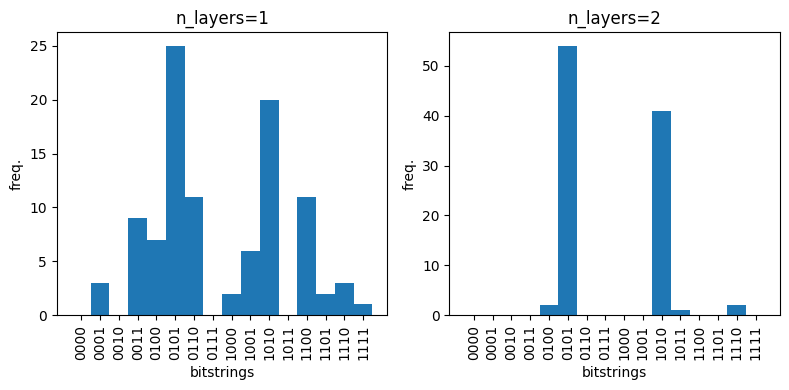

In [13]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)
plt.subplot(1, 2, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)
plt.tight_layout()
plt.show()

In [41]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit(x):
    qml.RX(x, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliY(0))

In [42]:
circuit(0.5)

tensor(-0.47942554, requires_grad=True)